In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

In [3]:

# for SVM
from classifiers.convex.svm import BinarySVM
from classifiers.kernel import Kernel
from classifiers.datasets.dataloader import Example_4x2
# for QASVM
from classifiers.quantum import Qasvm_Mapping_4x2
from classifiers.quantum.qasvm import QASVM
from classifiers.quantum.quantum_circuits import AnsatzCircuit9
from classifiers.optimizer import SPSA
from qiskit.utils import QuantumInstance
from qiskit.ignis.mitigation import CompleteMeasFitter
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, NLocal, TwoLocal
from qiskit.providers.aer import AerSimulator
from qiskit import IBMQ
# for logging & visualization
import logging
from classifiers.callback import CostParamStorage, ParamsStopping
from torch.utils.tensorboard import SummaryWriter
from classifiers.visualization import Plot_Data, Plot_Log_From_SPSA, Plot_SVM, compare_svm_and_qasvm

if IBMQ.active_account() is None:
    IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-kaist', group='internal', project='default')
backend = provider.get_backend('ibmq_toronto')
backend

<IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-kaist', group='internal', project='default')>

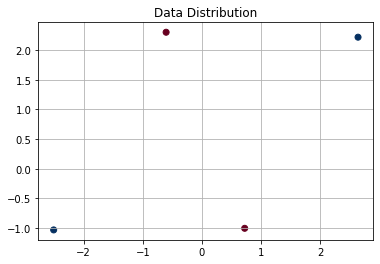

In [4]:
X, y = Example_4x2(True)()
Plot_Data(X, y).plot()

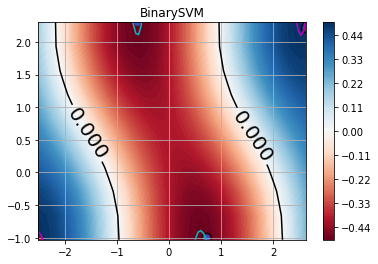

In [5]:
svm = BinarySVM(Kernel('SingleQubit', reps=1), mutation='REDUCED_QASVM', C=None, k=10)
svm.fit(X, y)
Plot_SVM(svm).plot_boundary()

54
51


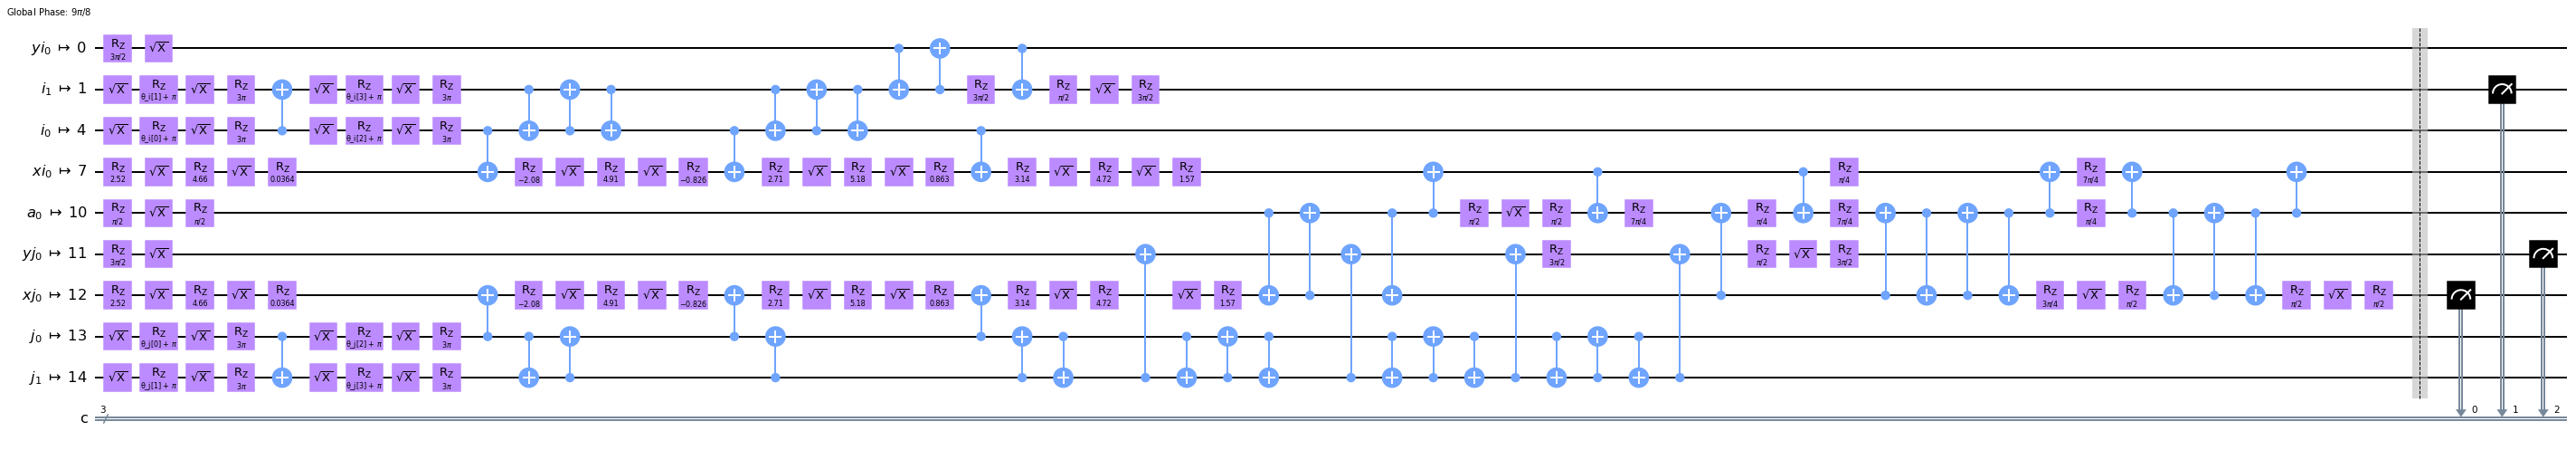

In [6]:
var_form = RealAmplitudes(2, reps=1)
#var_form = AnsatzCircuit9(2, reps=1, rotational_block='rx', entangling_block='cz')
#var_form = TwoLocal(2, reps=5, rotation_blocks='rz', entanglement_blocks='cx', entanglement='linear')
#var_form = EfficientSU2(2, reps=1)
quantum_instance = QuantumInstance(AerSimulator.from_backend(backend), shots=2**13, seed_transpiler=100, optimization_level=2, initial_layout=Qasvm_Mapping_4x2(backend), measurement_error_mitigation_cls=CompleteMeasFitter)
qasvm = QASVM(X, y, quantum_instance=quantum_instance, C=None, k=10, option='Bloch_sphere', var_form=var_form).dual
print(qasvm.second_order_circuit.depth())
print(qasvm.first_order_circuit.depth())
qasvm.second_order_circuit.draw(fold=-1, output='mpl', idle_wires=False)

In [7]:
from tqdm.notebook import tqdm
def find_min_seed(quantum_instance):
    old_tv = 1000
    for i in tqdm(range(100)):
        old_seed = quantum_instance.compile_config['seed_transpiler']
        quantum_instance.compile_config['seed_transpiler'] = i
        qasvm = QASVM(X, y, quantum_instance=quantum_instance, C=None, k=10, option='Bloch_sphere', var_form=var_form).dual
        new_tv = qasvm.second_order_circuit.depth() + qasvm.first_order_circuit.depth() + np.abs(qasvm.second_order_circuit.depth() - qasvm.first_order_circuit.depth())**2
        if new_tv < old_tv:
            old_tv = new_tv
        else:
            quantum_instance.compile_config['seed_transpiler'] = old_seed
    return quantum_instance.compile_config['seed_transpiler']

In [8]:
seed=find_min_seed(quantum_instance)
print(seed)

  0%|          | 0/100 [00:00<?, ?it/s]

52


50
51


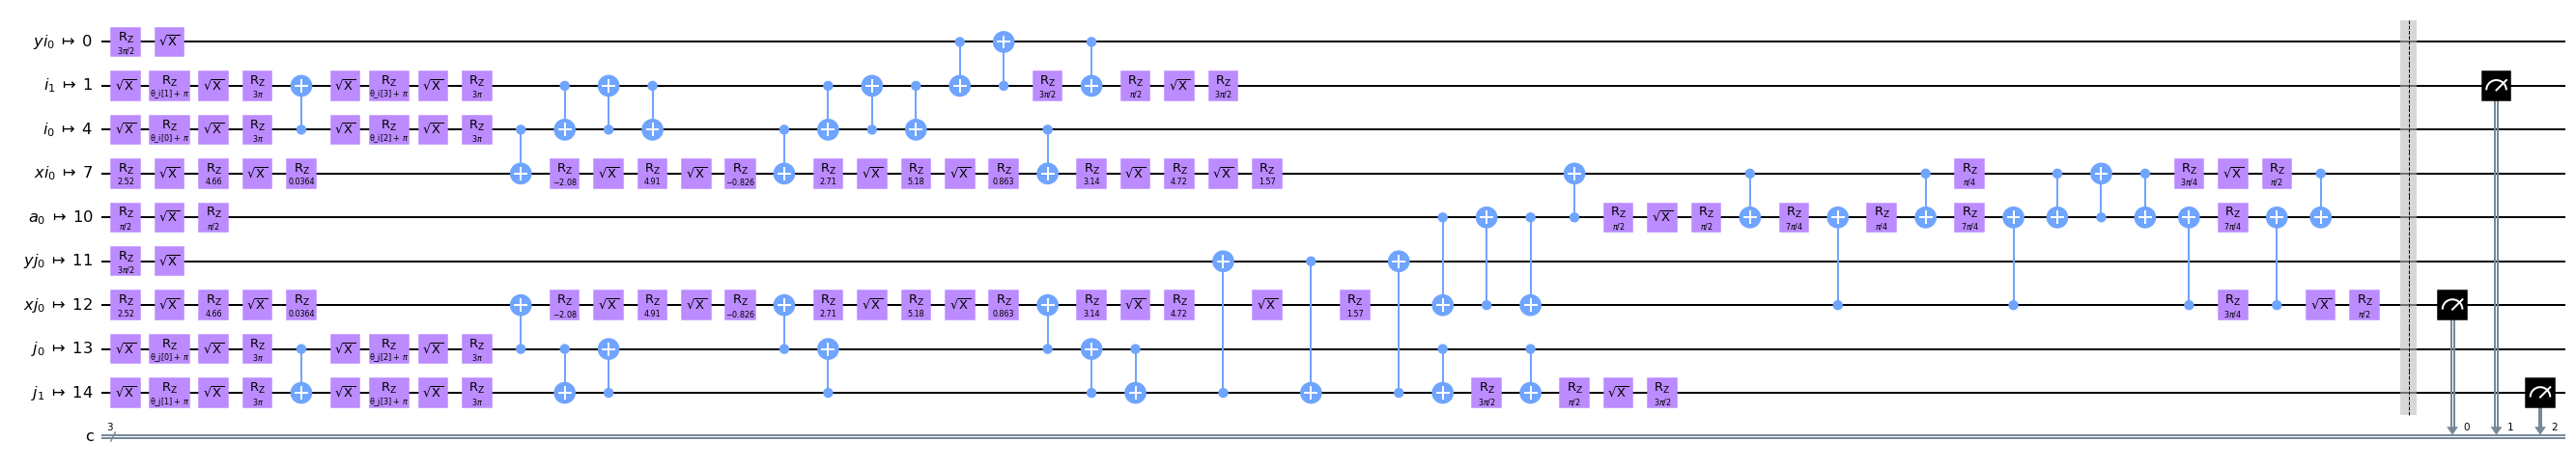

In [9]:
quantum_instance = QuantumInstance(AerSimulator.from_backend(backend), shots=2**13, seed_transpiler=seed, optimization_level=2, initial_layout=Qasvm_Mapping_4x2(backend), measurement_error_mitigation_cls=CompleteMeasFitter)
qasvm = QASVM(X, y, quantum_instance=quantum_instance, C=None, k=10, option='Bloch_sphere', var_form=var_form).dual
print(qasvm.second_order_circuit.depth())
print(qasvm.first_order_circuit.depth())
qasvm.second_order_circuit.draw(fold=-1, output='mpl', idle_wires=False)

In [10]:
from tqdm.notebook import tqdm

epochs = 2**10
last_avg = 16
optimizer = SPSA(qasvm, blocking=True)
storage = CostParamStorage(interval=1)

for epoch in tqdm(range(epochs), desc='SPSA opt'):
    optimizer.step(storage)
    if storage.num_accepted()>=last_avg and storage.last_cost_std(last_avg, ignore_rejected=True)<=optimizer.allowed_increase/2:
        break

qasvm.parameters = storage.last_avg(last_avg)


SPSA opt:   0%|          | 0/1024 [00:00<?, ?it/s]

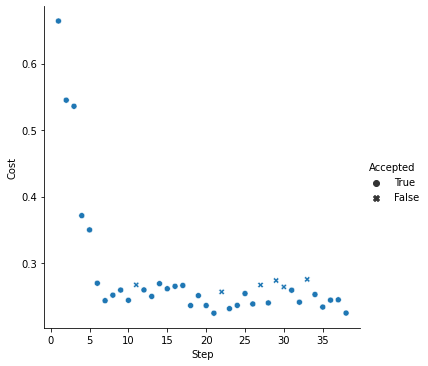

In [11]:
storage.plot()

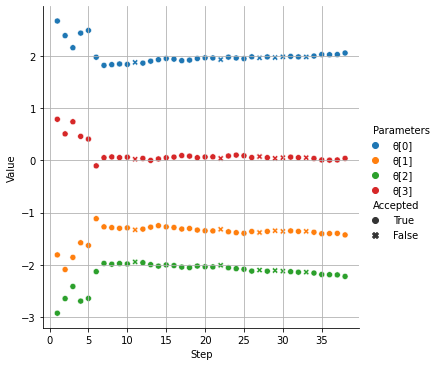

In [12]:
storage.plot_params()

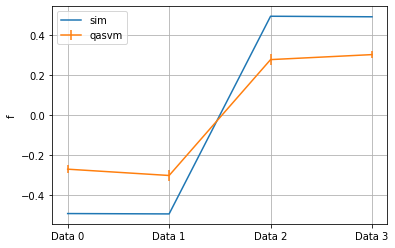

In [13]:
regression = compare_svm_and_qasvm(svm, qasvm)

50
51


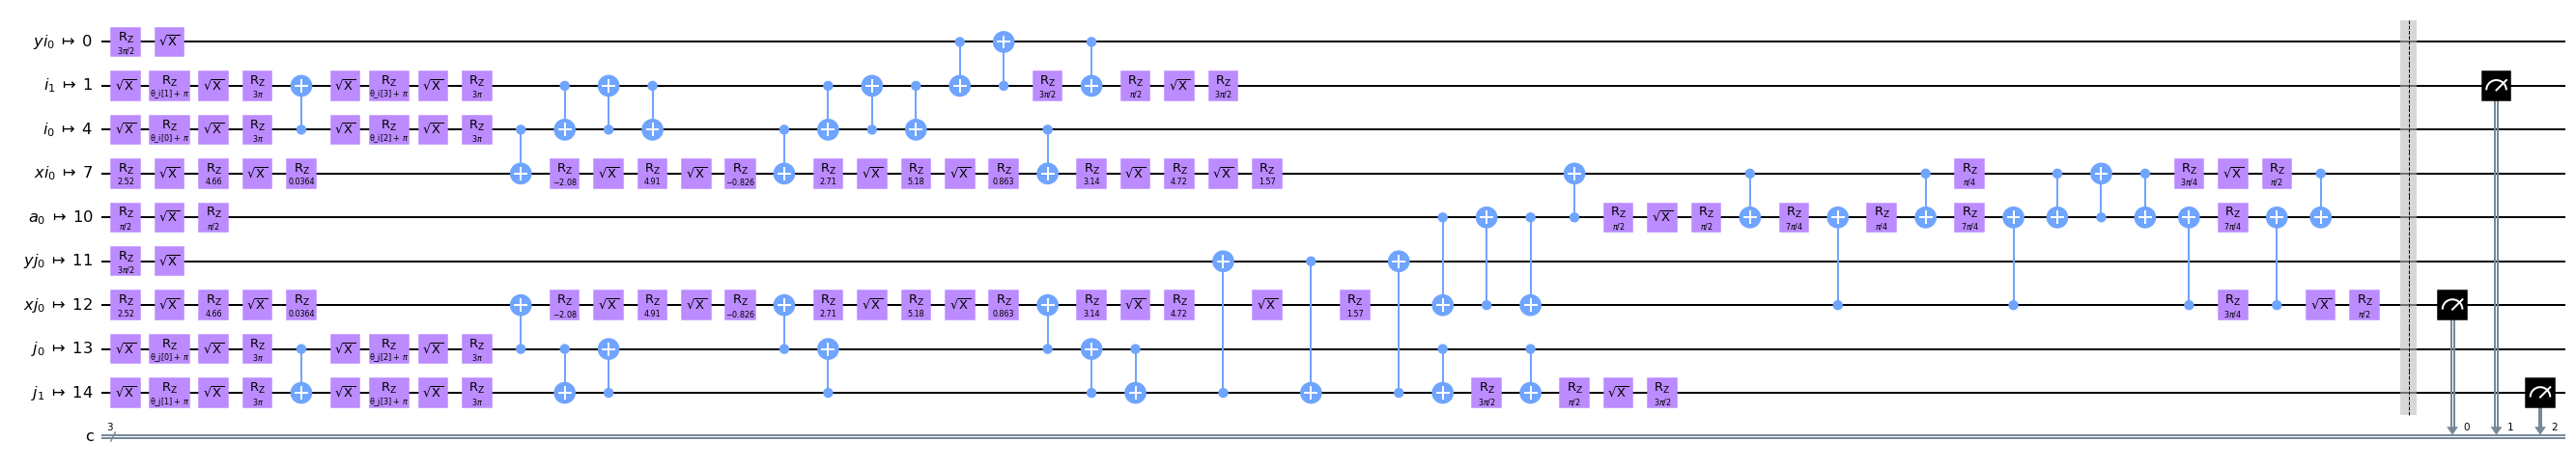

In [15]:
real_quantum_instance = QuantumInstance(backend=backend, shots=2**13, seed_transpiler=seed, optimization_level=2, initial_layout=Qasvm_Mapping_4x2(backend), measurement_error_mitigation_cls=CompleteMeasFitter)
real_qasvm = QASVM(X, y, quantum_instance=real_quantum_instance, C=None, k=10, option='Bloch_sphere', var_form=var_form).dual
print(real_qasvm.second_order_circuit.depth())
print(real_qasvm.first_order_circuit.depth())
real_qasvm.second_order_circuit.draw(fold=-1, output='mpl', idle_wires=False)

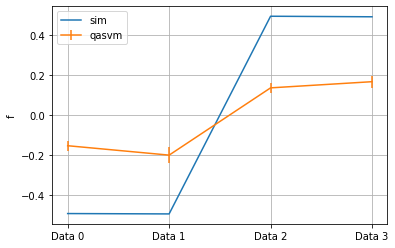

In [17]:
real_qasvm.parameters = storage.last_avg(last_avg)
real_regression = compare_svm_and_qasvm(svm, real_qasvm)



In [21]:
qasvm.save('./model/real/simulation_toronto_qasvm')
storage.save('./model/real/simulation_toronto_storage')
np.save('./model/real/simulation_toronto_regression.npy', regression)


In [23]:
real_qasvm.save('./model/real/real_toronto_qasvm')
np.save('./model/real/real_toronto_regression.npy', real_regression)

In [24]:
import dill
with open('./model/real/real_toronto_qasvm', 'rb') as f:
    loaded_obj = dill.load(f)
loaded_obj

Dual_QASVM (C=None, k=10)
Circuit Class: Bloch_sphere_QASVM_circuit
QuantumInstance: 
Qiskit Terra version: 0.17.2
Backend: 'ibmq_toronto (<AccountProvider for IBMQ(hub='ibm-q-kaist', group='internal', project='default')>)', with following setting:
{'basis_gates': ['id', 'rz', 'sx', 'x', 'cx', 'reset'], 'coupling_map': [[0, 1], [1, 0], [1, 2], [1, 4], [2, 1], [2, 3], [3, 2], [3, 5], [4, 1], [4, 7], [5, 3], [5, 8], [6, 7], [7, 4], [7, 6], [7, 10], [8, 5], [8, 9], [8, 11], [9, 8], [10, 7], [10, 12], [11, 8], [11, 14], [12, 10], [12, 13], [12, 15], [13, 12], [13, 14], [14, 11], [14, 13], [14, 16], [15, 12], [15, 18], [16, 14], [16, 19], [17, 18], [18, 15], [18, 17], [18, 21], [19, 16], [19, 20], [19, 22], [20, 19], [21, 18], [21, 23], [22, 19], [22, 25], [23, 21], [23, 24], [24, 23], [24, 25], [25, 22], [25, 24], [25, 26], [26, 25]]}
{'initial_layout': Layout({
10: Qubit(QuantumRegister(1, 'a'), 0),
4: Qubit(QuantumRegister(2, 'i'), 0),
1: Qubit(QuantumRegister(2, 'i'), 1),
7: Qubit(Quant

In [25]:
from qiskit.circuit.library import ZZFeatureMap

In [44]:
qc = ZZFeatureMap(3, reps=1)

In [46]:
qc.draw('mpl', fold=-1).savefig('/home/quic/image.png', dpi=100)

In [52]:
AnsatzCircuit9(3, reps=1).draw('mpl', fold=-1).savefig('/home/quic/image2.png', dpi=100)